# US testing: Exploratory Data Analysis

We want to plot 



In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

FILTERED_REGIONS = [
    'Virgin Islands',
    'American Samoa',
    'Northern Mariana Islands',
    'Guam',
    'Puerto Rico']

## Interaction between population size and testing strategies

If we knew the truth $\bar Y_N$ then

$$ Z_{n,N} = \frac{\bar Y_n - \bar Y_N}{\sqrt{V_{SRS} (\bar Y_n)}} = \sqrt{N-1} \rho_{I,Y} $$

If testing strategies were constant across 


In [ ]:
# Real-World Application to US Data

### Setup

Load US state case data from the NYT archive

In [57]:
url = 'https://covidtracking.com/api/v1/states/daily.csv'
states = pd.read_csv(url,
                     usecols=[0,1,2,3,16],
                     index_col=['state', 'date'],
                     parse_dates=['date'],
                     squeeze=True).sort_index()

(date
 2020-03-05     515.0
 2020-03-06     522.0
 2020-03-07     531.0
 2020-03-08     550.0
 2020-03-09     804.0
 2020-03-10     823.0
 2020-03-11    1073.0
 2020-03-12    1118.0
 2020-03-13    1118.0
 Name: CA cases, dtype: float64,
 date
 2020-03-05     53.0
 2020-03-06     60.0
 2020-03-07     69.0
 2020-03-08     88.0
 2020-03-09    114.0
 2020-03-10    133.0
 2020-03-11    157.0
 2020-03-12    202.0
 2020-03-13    202.0
 Name: CA positive cases, dtype: float64)

## Data cleaning in-line with 

Taking a look at the state, we need to start the analysis when there are a consistent number of cases each day. Find the last zero new case day and start on the day after that.

Also, case reporting is very erratic based on testing backlogs, etc. To get the best view of the 'true' data we can, I've applied a gaussian filter to the time series. This is obviously an arbitrary choice, but you'd imagine the real world process is not nearly as stochastic as the actual reporting.

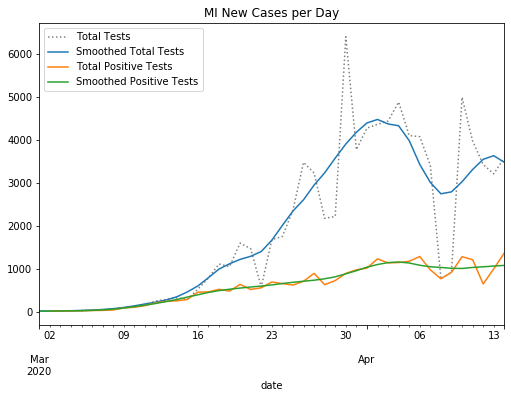

In [67]:
state_name = 'MI'

def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

total = states.xs(state_name)['total'].rename(f"{state_name} cases")
positive = states.xs(state_name)['positive'].rename(f"{state_name} positive cases")

original, smoothed = prepare_cases(total)
original_positive, smoothed_positive = prepare_cases(positive)

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Total Tests',
               legend=True,
             figsize=(600/72, 400/72))

ax = smoothed.plot(label='Smoothed Total Tests',
                   legend=True)
ax.get_figure().set_facecolor('w')

ax2 = original_positive.plot(label='Total Positive Tests',
                            legend=True)
ax2.get_figure().set_facecolor('w')

ax3 = smoothed_positive.plot(label='Smoothed Positive Tests',
                            legend=True)
ax3.get_figure().set_facecolor('w')